In [12]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')

In [39]:
cornel_box = mi.load_file("./scenes/cbox_one_ball.xml")
img = mi.render(cornel_box, spp=128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


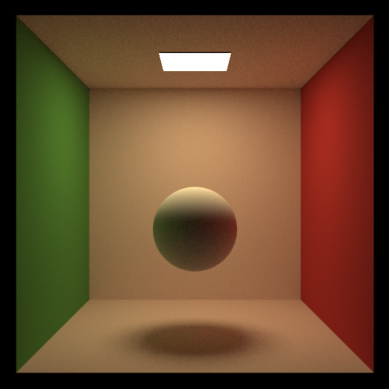

In [40]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(img ** (1/2.2))
mi.util.write_bitmap('trans_sensor.exr', img)

In [6]:
params = mi.traverse(cornel_box)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type  Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float PerspectiveCamera
  sensor.far_clip                               float PerspectiveCamera
  sensor.shutter_open                           float PerspectiveCamera
  sensor.shutter_open_time                      float PerspectiveCamera
  sensor.film.size                              ScalarVector2u HDRFilm
  sensor.film.crop_size                         ScalarVector2u HDRFilm
  sensor.film.crop_offset                       ScalarPoint2u HDRFilm
  sensor.x_fov                         ∂, D     Float PerspectiveCamera
  sensor.to_world                      ∂, D     Transform4f PerspectiveCamera
  gray.reflectance.value               ∂        Color3f SRGBReflectanceSpectrum
  white.re

In [7]:
print(params['graysphere.to_world'])

[[[0.3, 0, 0, 0],
  [0, 0.3, 0, -0.25],
  [0, 0, 0.3, 0.2],
  [0, 0, 0, 1]]]


In [23]:
import numpy as np
ROT_CENT = np.array([0, -.25, .2])
ROT_AX = np.array([0, 0, 1])
ROT_RAD = .5
SPHERE_RAD = .3
def get_to_world_mat(t : float):
    tmp_mat = np.array(
       [[SPHERE_RAD, .0, ROT_CENT[0], ROT_CENT[0] + np.sin(np.pi * 2 * t) * ROT_RAD], 
         [.0, SPHERE_RAD, 0, ROT_CENT[1] + np.cos(np.pi * 2 * t) * ROT_RAD],
         [.0, .0, SPHERE_RAD, ROT_CENT[2]],
         [.0, .0, .0, .1]
       ]
    )
    return mi.Transform4f(tmp_mat)

# def get_to_world_mat(t : float):
#     return mi.Transform4f().rotate(axis=ROT_AX, angle=t*360).translate(ROT_CENT + np.array([0, 0, ROT_RAD]))



In [24]:
print(get_to_world_mat(.4))

[[[0.3, 0, 0, 0.293893],
  [0, 0.3, 0, -0.654508],
  [0, 0, 0.3, 0.2],
  [0, 0, 0, 0.1]]]


In [25]:
FRAME_CNT=20

aov_int = mi.load_dict({
    'type': 'aov',
    'aovs': 'albedo:albedo,normals:sh_normal,depth:depth,position:position',
    'integrator': {
        'type': 'path',
    }
})

cur_frame = 0
for t in np.linspace(0, 1, FRAME_CNT):
    mat = get_to_world_mat(t)
    params['graysphere.to_world'] = mat
    params.update()
    frame = mi.render(cornel_box, integrator=aov_int, spp=2048)
    col_img = frame[:,:,0:3]
    mi.util.write_bitmap('./in/beauty_{}.exr'.format(cur_frame), col_img)
    alb_img = frame[:,:,3:6]
    mi.util.write_bitmap('./in/albedo_{}.exr'.format(cur_frame), alb_img)
    norm_img = frame[:,:,6:9]
    mi.util.write_bitmap('./in/normal_{}.exr'.format(cur_frame), norm_img)
    dep_img = frame[:,:,9:10]
    mi.util.write_bitmap('./in/depth_{}.exr'.format(cur_frame), dep_img)
    pos_img = frame[:,:,10:13]
    mi.util.write_bitmap('./in/position_{}.exr'.format(cur_frame), pos_img)
    cur_frame+=1